In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
csv_files=["/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_verified.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/whisper_tapas_verif_vad_chunk.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_whisper_large-tapas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_vad_whisper_medium.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_whisper_medium.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_hmm_tdnn_rouas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_conf_ester_rouas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_conf_cv_rouas.csv"]
labels = ["Wav2vec", "Whisper-VAD-chunk","Whisper-large-VAD-chunk","Whisper-VAD","Whisper-medium","HMM-TDNN","Conformer(ester)","Conformer(CV)"]
#csv_files=["/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_rhap.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_rhap_whisper_medium.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/whisper_rhap_vad_chunk.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_whisper_large-vad-chunk_rhap.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_hmm_tdnn_rouas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_rhap_conformer_rouas.csv"]
#labels =["wav2vec","Whisper-medium","Whisper-VAD-chunk","Whisper-large-VAD-chunk","Hmm-TDNN(ester)","Conformer(ester)"]
#csv_files = ["/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_£files/wer_typaloc_CEREB_wav2vec.csv",""]
#labels = ["CEREB"]
wer_data = []
for ids,f in enumerate(csv_files):
    d=f"Data {ids}"
    d=pd.read_csv(f)
    wer_data.append(d["WER"].dropna())

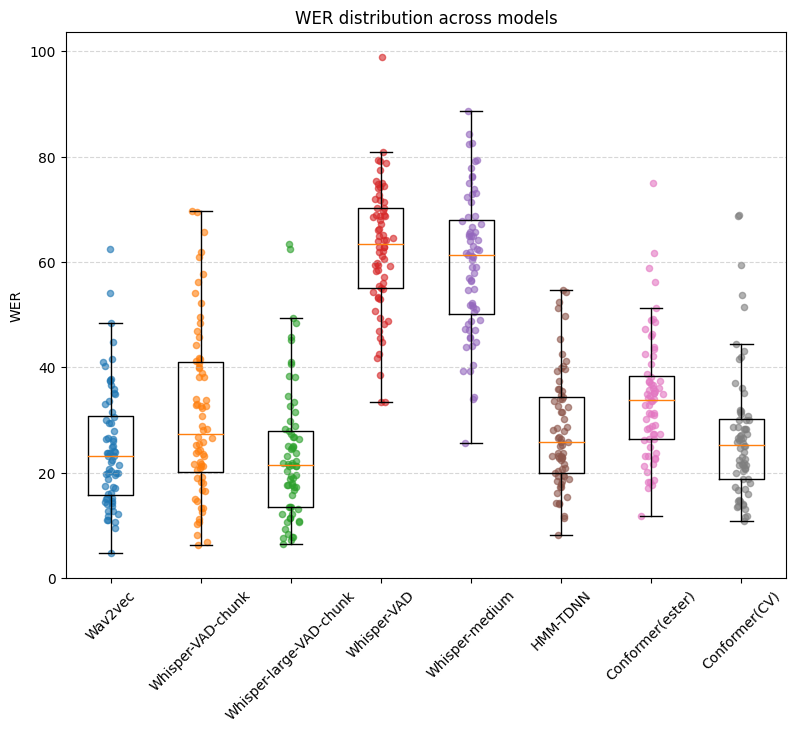

In [4]:
plt.figure(figsize=(8, 6))

# Boxplot
plt.boxplot(wer_data, labels=labels, showfliers=False)

# Overlay data points
for i, values in enumerate(wer_data, start=1):
    x = np.random.normal(i, 0.04, size=len(values))  # jitter
    plt.scatter(x, values, alpha=0.6, s=20)
plt.tight_layout()
plt.ylabel("WER")
plt.xticks(rotation=45)
plt.title("WER distribution across models")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.savefig("/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/wer_rhap_plot.png")
plt.show()


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

experiments = ["Wav2vec", "Whisper-VAD-chunk","Whisper-large-VAD-chunk"]
datasets = ["CEREB", "PARK", "SLA", "CTR"]
folder_path="/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/"
files = {
    "Wav2vec": [folder_path+"wer_typaloc_CEREB_wav2vec.csv", folder_path+"wer_typaloc_PARK_wav2vec.csv", folder_path+"wer_typaloc_SLA_wav2vec.csv", folder_path+"wer_typaloc_CTR_wav2vec.csv"],
    "Whisper-VAD-chunk": [folder_path+"wer_typaloc_CEREB_whisper-VAD-chunk.csv",folder_path+"whisper_PARK_VAD_chunk.csv",folder_path+"whisper_SLA_vad_chunk.csv",folder_path+"whisper_CTR_vad_chunk.csv"],
    "Whisper-large-VAD-chunk":[folder_path+"wer_whisper_large-VAD-chunk_CEREB.csv",folder_path+"wer_whisper_large-VAD-chunk_PARK.csv",folder_path+"wer_whisper_large-VAD-chunk_SLA.csv",folder_path+"wer_whisper_large-vad-chunk_CTRL.csv"]    
}

# Load data
data = {}
for exp in experiments:
    data[exp] = []
    for f in files[exp]:
        df = pd.read_csv(f)
        data[exp].append(df["WER"].dropna().values)



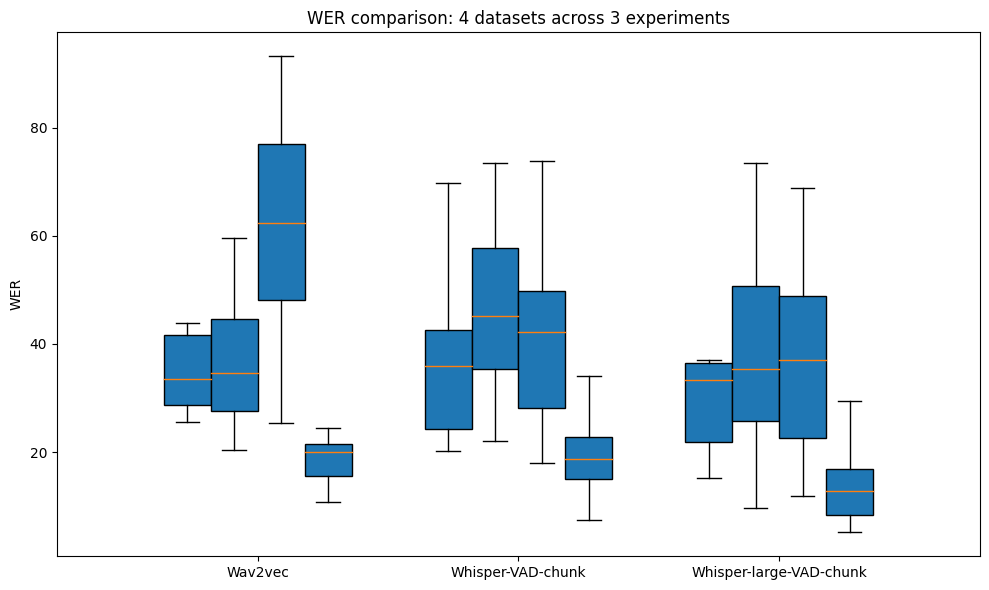

In [5]:
# Plot
plt.figure(figsize=(10, 6))

n_datasets = len(datasets)
width = 0.18
x = np.arange(len(experiments))

for i in range(n_datasets):
    plt.boxplot(
        [data[exp][i] for exp in experiments],
        positions=x + i * width,
        widths=width,
        patch_artist=True,
        showfliers=False
    )

# X-axis formatting
plt.xticks(x + width * (n_datasets - 1) / 2, experiments, rotation=0)
plt.ylabel("WER")
plt.title("WER comparison: 4 datasets across 3 experiments")

plt.tight_layout()
plt.show()


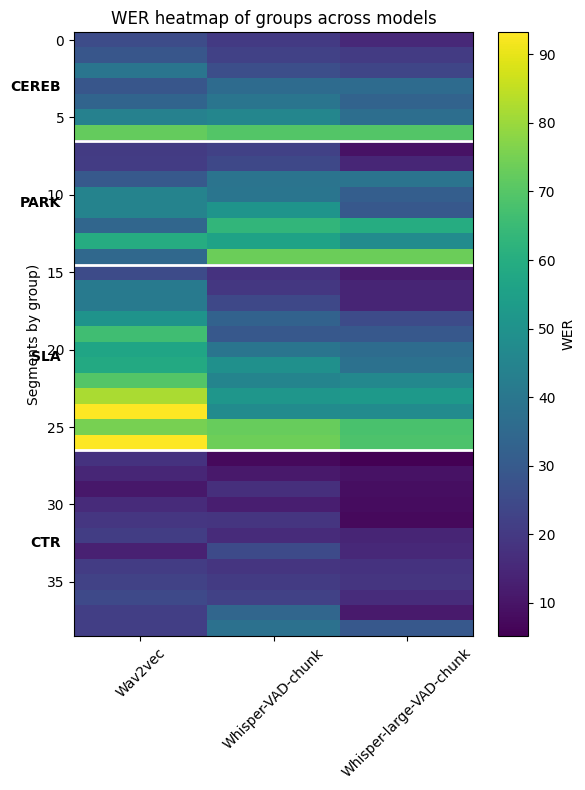

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Build one big matrix
all_rows = []
row_labels = []
dataset_boundaries = []

row_count = 0

for d_idx, dataset in enumerate(datasets):
    # matrix: samples × experiments
    mat = np.column_stack([
    data[exp][d_idx] for exp in experiments
    ])

    # 🔽 SORT HERE (low → high mean WER)
    order = np.argsort(mat.mean(axis=1))
    mat = mat[order]
    

    all_rows.append(mat)

    # labels (optional: file index)
    row_labels.extend([f"{dataset}_s{i}" for i in range(mat.shape[0])])

    row_count += mat.shape[0]
    dataset_boundaries.append(row_count)

# Concatenate everything
big_mat = np.vstack(all_rows)

# Plot
plt.figure(figsize=(6, 8))
im = plt.imshow(big_mat, aspect="auto", cmap="viridis")
start = 0
for d_idx, dataset in enumerate(datasets):
    n_rows = all_rows[d_idx].shape[0]
    center = start + n_rows / 2 - 0.5

    plt.text(
        -0.6, center, dataset,
        va="center", ha="right",
        fontsize=10, fontweight="bold"
    )

    start += n_rows

plt.xticks(range(len(experiments)), experiments, rotation=45)
plt.ylabel("Segments by group)")
plt.title("WER heatmap of groups across models")

# Dataset separators
for y in dataset_boundaries[:-1]:
    plt.axhline(y - 0.5, color="white", linewidth=2)

plt.colorbar(im, label="WER")
plt.savefig("/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/wer_typaloc_heatmap.png")

plt.tight_layout()
plt.show()
